In [1]:
# !pip install --user matplotlib seaborn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [4]:
from bert.model import create_albert_model

model = create_albert_model(model_dimension=512,
                            transformer_dimension=512 * 4,
                            num_attention_heads=512 // 64,
                            num_transformer_layers=6,
                            vocab_size=24,
                            dropout_rate=0.,
                            max_relative_position=64,
                            final_layernorm=True)


model.load_weights('/scratch/pstjohn/uniparc_checkpoints/sl1024_debug/saved_weights')

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         12288     
_________________________________________________________________
transformer (Transformer)    ((None, None, 512), (None 2897984   
_________________________________________________________________
transformer_1 (Transformer)  ((None, None, 512), (None 2897984   
_________________________________________________________________
transformer_2 (Transformer)  ((None, None, 512), (None 2897984   
_________________________________________________________________
transformer_3 (Transformer)  ((None, None, 512), (None 2897984   
_________________________________________________________________
transformer_4 (Transformer)  ((None, None, 512), (None 289798

In [6]:
summed_attention = tf.reduce_sum(tf.keras.layers.add(
    [l.output[1] for l in model.layers[2:-2]]), axis=1)
attention_model = tf.keras.models.Model(model.input, summed_attention)

In [7]:
from bert.dataset import create_masked_input_dataset

valid_data = create_masked_input_dataset(
    sequence_path='../uniparc_data/dev_uniref50.txt.gz',
    max_sequence_length=1024,
    batch_size=10)

In [8]:
masked_seq, true_values = next(iter(valid_data))

In [9]:
from bert.losses import ECE
predictions = model.predict(masked_seq)
ECE(true_values, predictions)

<tf.Tensor: id=6287, shape=(), dtype=float32, numpy=12.7204>

In [10]:
masked_entries = tf.not_equal(true_values, 0)
y_true_mask = tf.boolean_mask(true_values, masked_entries)
y_logit_mask = tf.boolean_mask(predictions, masked_entries)
y_pred_mask = y_logit_mask.numpy().argmax(-1)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(y_true_mask.numpy(), y_pred_mask)

0.24789915966386555

In [13]:
y_true_mask.numpy().shape

(476,)

In [14]:
aas = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
confusion_mat = pd.DataFrame([y_pred_mask, y_true_mask.numpy()], index=['Pred', 'True']
                            ).T.groupby(['Pred', 'True']).size().reset_index().pivot(
    index='True', columns='Pred', values=0).fillna(0)

confusion_mat.index = aas
confusion_mat.columns = aas

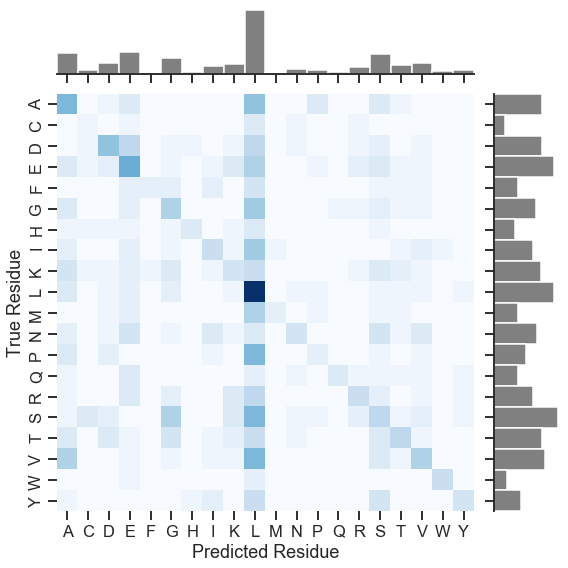

In [118]:
height = 8
ratio = 5

# Set up the subplot grid
f = plt.figure(figsize=(height, height))
gs = plt.GridSpec(ratio + 1, ratio + 1)

ax_joint = f.add_subplot(gs[1:, :-1])
ax_marg_x = f.add_subplot(gs[0, :-1], sharex=ax_joint)
ax_marg_y = f.add_subplot(gs[1:, -1], sharey=ax_joint)

fig = f
ax_joint = ax_joint
ax_marg_x = ax_marg_x
ax_marg_y = ax_marg_y

# Turn off tick visibility for the measure axis on the marginal plots
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Turn off the ticks on the density axis for the marginal plots
plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
plt.setp(ax_marg_x.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=False)
ax_marg_x.yaxis.grid(False)
ax_marg_y.xaxis.grid(False)

sns.heatmap(confusion_mat, ax=ax_joint, cbar=False, cmap='Blues')
_ = ax_marg_x.bar(aas, height=confusion_mat.sum(0), width=1., align='edge', facecolor='.5')
_ = ax_marg_y.barh(aas, width=confusion_mat.sum(1), height=1., align='edge', facecolor='.5')

sns.despine(ax=ax_marg_x, left=True)
sns.despine(ax=ax_marg_y, bottom=True)

_ = ax_joint.set_xticks(np.arange(20) + 0.5)
_ = ax_joint.set_xticklabels(aas)
_ = ax_joint.set_yticks(np.arange(20) + 0.5)
_ = ax_joint.set_yticklabels(aas)

ax_joint.set_ylabel('True Residue')
ax_joint.set_xlabel('Predicted Residue')

plt.tight_layout()
plt.savefig('figures/confusion_matrix.svg')

In [72]:
attentions = attention_model(masked_seq).numpy()

In [74]:
(masked_seq[2] != 0).numpy().sum()

290

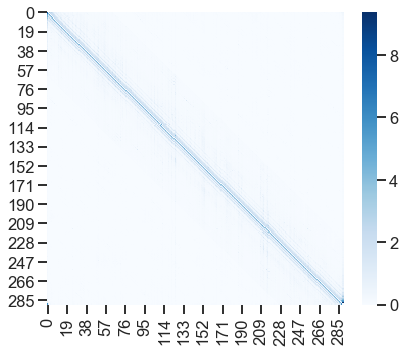

In [116]:
plt.figure(figsize=(6,5))
sns.heatmap(attentions[2, :290, :290], cmap='Blues')
plt.tight_layout()
plt.savefig('figures/attention_map.svg')

In [94]:
di = list(np.diag_indices(290))

def get_offset(i):
    return attentions[2, di[0][20:-20] + i, di[1][20:-20]] / 40.

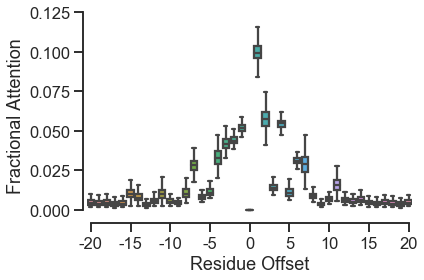

In [111]:
sns.boxplot(data=pd.DataFrame([get_offset(i) for i in np.arange(-20, 21)], index=np.arange(-20, 21)).T, fliersize=0)
plt.xticks(ticks=np.arange(0, 45, 5), labels=np.arange(-20, 25, 5))
sns.despine(trim=True, offset=4)
plt.xlabel('Residue Offset')
plt.ylabel('Fractional Attention')
plt.tight_layout()
plt.savefig('figures/attention_offset.svg')

In [100]:
np.arange(-20, 20, 5)

array([-20, -15, -10,  -5,   0,   5,  10,  15])

In [42]:
attentions[0]

<tf.Tensor: id=20431, shape=(514, 514), dtype=float32, numpy=
array([[0.        , 3.7826977 , 2.4085498 , ..., 0.        , 0.        ,
        0.        ],
       [4.671831  , 0.        , 2.8995018 , ..., 0.        , 0.        ,
        0.        ],
       [4.022781  , 3.4651406 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3182935 , 0.09666741, 0.09090118, ..., 0.        , 0.        ,
        0.        ],
       [0.3182935 , 0.09666741, 0.09090118, ..., 0.        , 0.        ,
        0.        ],
       [0.3182935 , 0.09666741, 0.09090118, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [ ]:
inputs = tf.keras.Model(model.layers[1].input, model.layers[1].output)(masked_seq)
inputs._keras_mask

In [ ]:
transformer = model.layers[2]

In [ ]:
self = transformer.attention_layer
mask = inputs._keras_mask
training=True

from bert.attention_utils import create_attention_mask, relative_attention_inner, initializer

In [ ]:
input_shape = tf.shape(inputs) # [B, S, N*H]

# query and key can be the same vector
qk = self.transpose_scores(self.qk_layer(inputs))  # [B,N,S,H]
value = self.transpose_scores(self.value_layer(inputs))  # [B,N,S,H]

# Equation 1 of "Attention is all you need"
attention_scores = self.calculate_attention(qk, input_shape)  # [B,N,S,S]

In [ ]:
inputs.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(self.relations_keys_embedding.weights[0].numpy())

In [ ]:
# zero out masked values
attention_mask = self.create_attention_mask(input_shape, mask)
attention_scores = attention_scores * 1000 + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores)  # [B,N,S,S]

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[2, 0].numpy())

In [ ]:
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[2, 0].numpy())

In [ ]:
context_layer = tf.transpose(a=context_layer, perm=[0, 2, 1, 3])            

In [ ]:
context_layer.shape

In [ ]:
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(context_layer[0, :, :10].numpy())

In [ ]:
mask = inputs._keras_mask
attention_mask = self.create_attention_mask(mask)
attention_scores_mask = attention_scores + (1. - attention_mask) * -10000.0
attention_probs = tf.nn.softmax(attention_scores_mask)  # [B,N,S,S]
context_layer = tf.matmul(attention_probs, value)  # [B,N,S,S]

input_shape  = tf.shape(inputs)
output_shape = [input_shape[0], input_shape[1], self.num_heads*self.units]
# context_layer = tf.reshape(context_layer, output_shape)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_scores_mask[3, 0].numpy())

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(attention_probs[3, 0].numpy())

In [ ]:
context_layer.shape

In [ ]:
context_layer.shape

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(tf.reshape(tf.transpose(a=context_layer, perm=[0, 2, 1, 3]), input_shape)[3].numpy())